In [1]:
#Importing Packages 
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
import h5py
import cv2 
from sklearn.metrics import classification_report


Using TensorFlow backend.


In [2]:
'''Mount this to your google drive location where data exists'''
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:


import glob
import os
#os.chdir('C:\\Users\\kaviy\\Downloads\\1512427\\brainTumorDataPublic_1-766')
#path_dir = os.fsencode('content/drive/My Drive/ML_proj/data')
#print(path_dir)
'''Uncomment the line below and please insert the directory where the numpy file exists'''
#os.chdir('/content/drive/')

'''Uncomment these following lines to load numpy files of images directly if working on google drive'''
# X = np.load('X.npy')
# Y = np.load('Y.npy')


In [4]:
#X.shape

(3049, 64, 64)

In [0]:
'''Use this if running on local machine'''

import glob
import os
'''Insert the directory where images exist (.mat data)'''
#os.chdir('')
files=glob.glob('*.mat')
X=[]
Y=[]
data=[]
count=0
#a = 1
for file in files:
  #print(file)
    with h5py.File(file,'r') as f:
        variables=f.items()
        for var in variables:
            name= var[0]
            data=var[1]
            if (np.array(data['tumorMask']).shape[1] == 256):
                count+=1
                print(count)
            else:
                d=data['image']
                X.append(cv2.resize(np.array(d),dsize=(64,64),interpolation=cv2.INTER_AREA))

                #X.append(np.array(d))
                #X.append(np.array(data['tumorMask']))
                Y.append(data['label'][0][0])

              #a = data['label'][0][0]



In [5]:
#np.array(X).shape

(3049, 64, 64)

In [6]:
#np.array(Y).shape

(3049,)

In [0]:
# Y = np.array(Y)
# Y=Y-1

In [0]:
# Y.shape

In [0]:
'''Data Preprocessing'''
X = np.array(X).reshape(-1,64,64, 1)
#Y=np.array(Y).reshape(-1,1,1,1)
#Y=Y.astype('float32')
# Y=Y/255.
X = X.astype('float32')
X = X / 255.


In [10]:
'''Initial Split'''
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25)
#X_train.shape , X_test.shape

((2286, 64, 64, 1), (763, 64, 64, 1))

In [11]:
#np.array(Y_test).shape , np.array(Y_train).shape

((763,), (2286,))

In [0]:
'''Scaling'''
X_train=X_train / np.max(X_train)

X_test=X_test / np.max(X_test)

In [0]:
'''Reconstruction of images using unsupervised learning'''
train_X,valid_X,train_ground,valid_ground = train_test_split(X_train,
                                                             X_train,
                                                             test_size=0.25,
                                                             random_state=0)

In [0]:
# Y_test.shape

In [0]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
num_classes = 3

In [0]:
'''Layer structure for reconstruction'''
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #64 x 64 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #32 x 32 x 32 #Reduces dimesnions
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #32 x 32 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #16 x 16 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #16 x 16 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #16 x 16 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
#     conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #16 x 16 x 128
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6) #16 x 16 x 64
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up1 = UpSampling2D((2,2))(conv7) #32 x 32 x 64 #Upsamling to get back same dimension reduced by max pooling
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 32 x 32 x 32
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    up2 = UpSampling2D((2,2))(conv8) # 64 x 64 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 64 x 64 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
'''Training to generate weights'''
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
#autoencoder_train = autoencoder.fit(train_X,train_ground, batch_size=batch_size,epochs=300,verbose=1,validation_data=(valid_X,valid_ground),callbacks=[callback_early_stopping])
autoencoder_train = autoencoder.fit(train_X,train_ground, batch_size=batch_size,epochs=1000,verbose=1,validation_data=(valid_X,valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 1714 samples, validate on 572 samples
Epoch 1/1000
1714/1714 [==============================] - 8s 4ms/step - loss: 0.0937 - val_loss: 0.1706
Epoch 2/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0373 - val_loss: 0.2976
Epoch 3/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0195 - val_loss: 0.7399
Epoch 4/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0101 - val_loss: 0.6502
Epoch 5/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0096 - val_loss: 0.1057
Epoch 6/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0088 - val_loss: 0.1238
Epoch 7/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 8/1000
1714/1714 [==============================] - 2s 1ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 9/1000
1714/1714 [==============================] - 2s 1ms/step - l

In [0]:
from keras.utils import to_categorical
Y_train=np.array(Y_train)-1
Y_train = to_categorical(Y_train)

In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

In [0]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [0]:
numclasses=3
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [0]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [25]:
'''Comparing to check that the weights are set correctly'''
autoencoder.get_weights()[0][1]

array([[[-0.11362907,  0.25356957, -0.11609847,  0.17133437,
          0.21598338,  0.00907517, -0.03094127,  0.2315397 ,
          0.180728  ,  0.014624  ,  0.02743706,  0.3285325 ,
         -0.08050322,  0.18555117, -0.27073142, -0.23844512,
          0.03366519, -0.27044278,  0.23921314, -0.03397636,
          0.00746475, -0.08939018, -0.21742521,  0.06729656,
         -0.13283393,  0.02616836,  0.02298508, -0.05252221,
         -0.00270513,  0.24633063, -0.12611526,  0.06411856]],

       [[-0.05995375, -0.13024835, -0.08822802,  0.28121138,
          0.8695374 , -0.07333606,  0.05115486,  0.12083048,
          0.08125699, -0.17007291, -0.22207038,  0.40457684,
         -0.09516051,  0.08190954,  0.06898218, -0.10013296,
          0.03262295, -0.32640663, -0.24349947,  0.19355413,
          0.25741628,  0.1910985 ,  0.11805422, -0.04609126,
          0.09000854, -0.20540766, -0.01685459, -0.2255084 ,
          0.02688038, -0.17870867,  0.16697122,  0.17078279]],

       [[-0.144097

In [26]:
full_model.get_weights()[0][1]

array([[[-0.11362907,  0.25356957, -0.11609847,  0.17133437,
          0.21598338,  0.00907517, -0.03094127,  0.2315397 ,
          0.180728  ,  0.014624  ,  0.02743706,  0.3285325 ,
         -0.08050322,  0.18555117, -0.27073142, -0.23844512,
          0.03366519, -0.27044278,  0.23921314, -0.03397636,
          0.00746475, -0.08939018, -0.21742521,  0.06729656,
         -0.13283393,  0.02616836,  0.02298508, -0.05252221,
         -0.00270513,  0.24633063, -0.12611526,  0.06411856]],

       [[-0.05995375, -0.13024835, -0.08822802,  0.28121138,
          0.8695374 , -0.07333606,  0.05115486,  0.12083048,
          0.08125699, -0.17007291, -0.22207038,  0.40457684,
         -0.09516051,  0.08190954,  0.06898218, -0.10013296,
          0.03262295, -0.32640663, -0.24349947,  0.19355413,
          0.25741628,  0.1910985 ,  0.11805422, -0.04609126,
          0.09000854, -0.20540766, -0.01685459, -0.2255084 ,
          0.02688038, -0.17870867,  0.16697122,  0.17078279]],

       [[-0.144097

In [0]:
'''Using generate weigths from other models hence first 19 layers are not disabled'''
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [0]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')

In [30]:
#classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=300,verbose=1,validation_data=(valid_X, valid_label),callbacks=[callback_early_stopping])
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=50,verbose=1,validation_data=(valid_X, valid_label))

Train on 1714 samples, validate on 572 samples
Epoch 1/50
1714/1714 [==============================] - 2s 1ms/step - loss: 9.7479 - acc: 0.3705 - val_loss: 9.2065 - val_acc: 0.4248
Epoch 2/50
1714/1714 [==============================] - 1s 387us/step - loss: 8.5748 - acc: 0.4632 - val_loss: 8.2473 - val_acc: 0.4878
Epoch 3/50
1714/1714 [==============================] - 1s 395us/step - loss: 5.8583 - acc: 0.6284 - val_loss: 4.8567 - val_acc: 0.6923
Epoch 4/50
1714/1714 [==============================] - 1s 398us/step - loss: 4.4226 - acc: 0.7200 - val_loss: 4.4882 - val_acc: 0.7150
Epoch 5/50
1714/1714 [==============================] - 1s 387us/step - loss: 4.0328 - acc: 0.7462 - val_loss: 4.2367 - val_acc: 0.7360
Epoch 6/50
1714/1714 [==============================] - 1s 391us/step - loss: 3.7866 - acc: 0.7614 - val_loss: 3.8753 - val_acc: 0.7517
Epoch 7/50
1714/1714 [==============================] - 1s 395us/step - loss: 3.6718 - acc: 0.7678 - val_loss: 4.1692 - val_acc: 0.7378
Epo

In [0]:
'''Resetting to true to use while predictions'''
for layer in full_model.layers[0:19]:
    layer.trainable = True

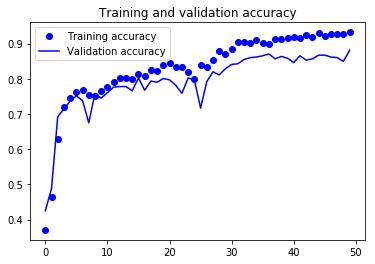

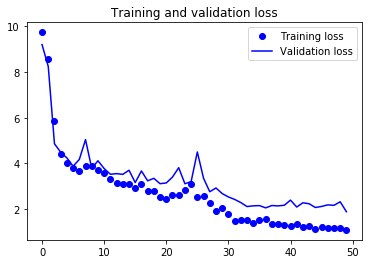

In [32]:
'''Plotting accuracy and loss'''
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
'''Predictions and Evaluations'''
test_eval = full_model.evaluate(valid_X,valid_label, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 1.878521731687622
Test accuracy: 0.8811188823693282


In [34]:
#np.array(valid_X).shape

(572, 64, 64, 1)

In [0]:
predicted_classes = full_model.predict(valid_X)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [0]:
valid_label = np.argmax(np.round(valid_label),axis=1)

In [38]:
predicted_classes

array([2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1,
       1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1,
       0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0,
       0, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1,
       2, 1, 1, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0,
       0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 2,
       1, 2, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 0, 2, 1, 0,
       1, 1, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2,
       2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0,

In [39]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(3)]
print(classification_report(valid_label, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.77      0.74      0.76       132
     Class 1       0.90      0.90      0.90       279
     Class 2       0.94      0.96      0.95       161

   micro avg       0.88      0.88      0.88       572
   macro avg       0.87      0.87      0.87       572
weighted avg       0.88      0.88      0.88       572



In [40]:
valid_label

array([2, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1,
       1, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1,
       0, 1, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0,
       0, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1,
       2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1,
       0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1,
       1, 2, 0, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0,
       1, 1, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2,
       1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 2,
       2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 0,